Loading data...
Data loaded: 7,305,000 rows, 66 columns
Date range: 2004-01-01 00:00:00 to 2023-12-31 00:00:00
Unique SKUs: 50
Unique Locations: 20

Preparing features...
Using 46 numeric features
Target: actual_demand

Checking missing values...
Missing values found:
elasticity_proxy         1521070
demand_yoy_pct_change    2363527
dtype: int64

Filling missing values with 0...

Splitting data...
Train set: 6,940,000 rows
Test set:  365,000 rows
Train date range: 2004-01-01 00:00:00 to 2022-12-31 00:00:00
Test date range:  2023-01-01 00:00:00 to 2023-12-31 00:00:00

Training XGBoost model...
Training complete!

Making predictions...

MODEL EVALUATION

TRAIN Metrics:
  MAE:  4.58
  RMSE: 19.18
  R²:   0.9851
  MAPE: 401540393310.65%

TEST Metrics:
  MAE:  4.41
  RMSE: 17.38
  R²:   0.9878
  MAPE: 349846175293.66%

TOP 20 FEATURE IMPORTANCE
              feature  importance
           chan_lag_1    0.316625
          day_of_week    0.302402
           is_weekend    0.121361
demand_yoy_p

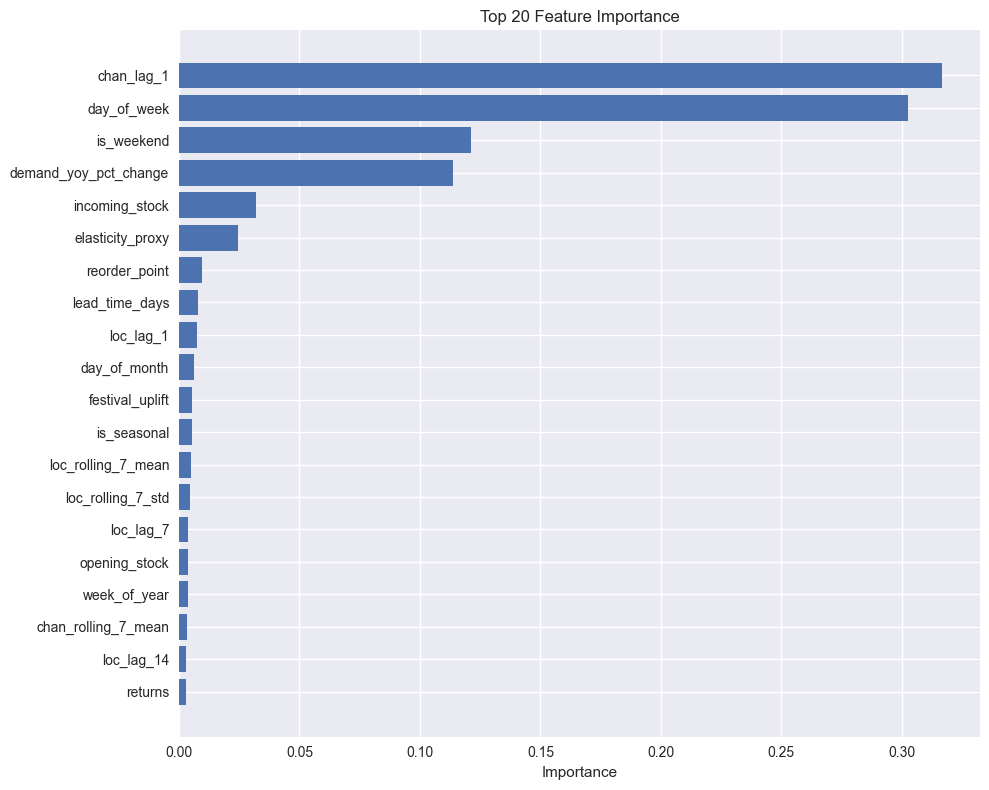

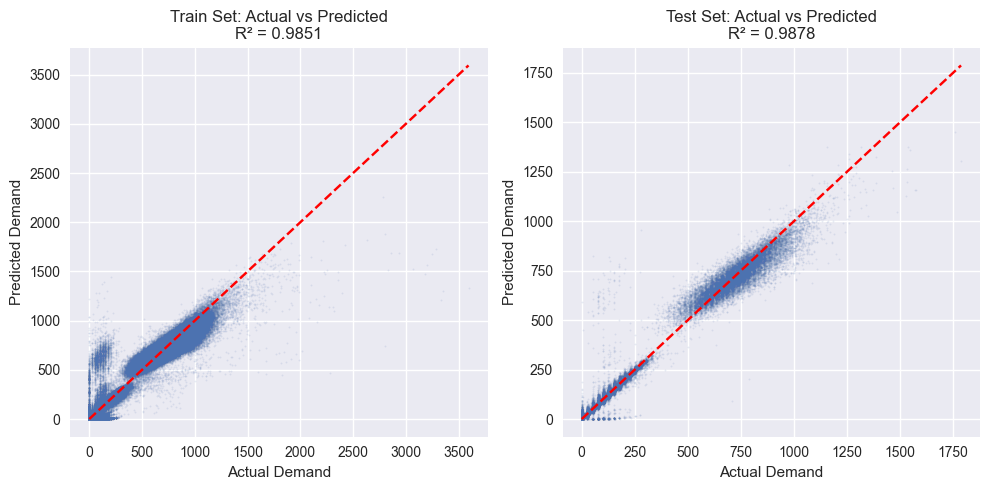

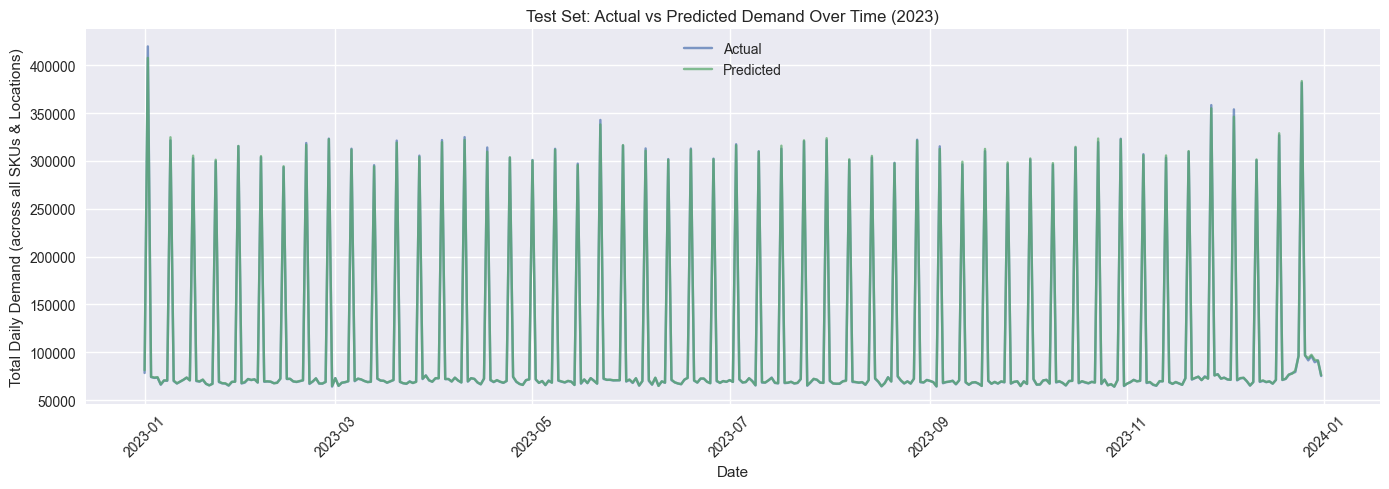


Saving model and results...
Model saved to: ../Shared project assets/data/processed/xgboost_baseline_model.json
Predictions saved to: ../Shared project assets/data/processed/test_predictions.csv
Feature importance saved to: ../Shared project assets/data/processed/feature_importance.csv
Metrics saved to: ../Shared project assets/data/processed/model_metrics.csv

BASELINE MODEL COMPLETE!


In [2]:
# ========================================
# BASELINE XGBOOST FORECASTING MODEL
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

plt.style.use('seaborn-v0_8')

# ========================================
# 1. LOAD DATA
# ========================================

print("Loading data...")
df = pd.read_csv(r"..\Shared project assets\data\raw\datasets\daily_timeseries.csv")

# Convert date
df['date'] = pd.to_datetime(df['date'])

print(f"Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique SKUs: {df['sku_id'].nunique()}")
print(f"Unique Locations: {df['location_id'].nunique()}")

# ========================================
# 2. PREPARE FEATURES AND TARGET
# ========================================

print("\nPreparing features...")

# Target variable
target = 'actual_demand'

# Columns to exclude from features
exclude_cols = [
    'date', 
    'actual_demand',     # target
    'expected_demand',   # leakage
    'unfulfilled_demand', # derived from target
    'sku_id',            # categorical ID
    'location_id',       # categorical ID
    'sku_name',          # text
    'city',              # text
    'brand',             # text (already have brand info in other features)
    'category',          # text (exclude for now, could encode later)
    'segment',           # text
    'pack_size',         # text
    'material',          # text
    'life_category',     # text
    'abc_class',         # text
    'region',            # text
    'location_type',     # text
    'distribution_tier', # text
    'channel',           # text
    'month',             # text/datetime (we have month features already)
]

# Select only numeric columns
all_cols = [col for col in df.columns if col not in exclude_cols]
feature_cols = df[all_cols].select_dtypes(include=['number']).columns.tolist()

print(f"Using {len(feature_cols)} numeric features")
print(f"Target: {target}")

# Show excluded object columns
object_cols = df[all_cols].select_dtypes(include=['object']).columns.tolist()
if object_cols:
    print(f"\nExcluded {len(object_cols)} text/object columns:")
    print(object_cols)

# ========================================
# 3. HANDLE MISSING VALUES
# ========================================

print("\nChecking missing values...")
missing = df[feature_cols + [target]].isna().sum()
missing_pct = (missing / len(df)) * 100

if missing.sum() > 0:
    print("Missing values found:")
    print(missing[missing > 0])
    print("\nFilling missing values with 0...")
    df[feature_cols] = df[feature_cols].fillna(0)
    df[target] = df[target].fillna(0)
else:
    print("No missing values found.")

# ========================================
# 4. TIME-BASED TRAIN/TEST SPLIT
# ========================================

print("\nSplitting data...")

# Train: 2004-2022 (19 years)
# Test: 2023 (1 year)
train_mask = df['date'] < '2023-01-01'
test_mask = df['date'] >= '2023-01-01'

X_train = df.loc[train_mask, feature_cols]
y_train = df.loc[train_mask, target]
X_test = df.loc[test_mask, feature_cols]
y_test = df.loc[test_mask, target]
test_dates = df.loc[test_mask, 'date']

print(f"Train set: {len(X_train):,} rows")
print(f"Test set:  {len(X_test):,} rows")
print(f"Train date range: {df.loc[train_mask, 'date'].min()} to {df.loc[train_mask, 'date'].max()}")
print(f"Test date range:  {df.loc[test_mask, 'date'].min()} to {df.loc[test_mask, 'date'].max()}")

# ========================================
# 5. TRAIN BASELINE XGBOOST MODEL
# ========================================

print("\nTraining XGBoost model...")

model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train, verbose=False)

print("Training complete!")

# ========================================
# 6. MAKE PREDICTIONS
# ========================================

print("\nMaking predictions...")

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Ensure non-negative predictions
y_train_pred = np.maximum(y_train_pred, 0)
y_test_pred = np.maximum(y_test_pred, 0)

# ========================================
# 7. EVALUATE MODEL
# ========================================

print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # Calculate RMSE manually
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}


train_metrics = calculate_metrics(y_train, y_train_pred, "TRAIN")
test_metrics = calculate_metrics(y_test, y_test_pred, "TEST")

# ========================================
# 8. FEATURE IMPORTANCE
# ========================================

print("\n" + "="*60)
print("TOP 20 FEATURE IMPORTANCE")
print("="*60)

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance_df.head(20).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ========================================
# 9. VISUALIZE PREDICTIONS
# ========================================

# Actual vs Predicted scatter plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.1, s=1)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title(f'Train Set: Actual vs Predicted\nR² = {train_metrics["R2"]:.4f}')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.1, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title(f'Test Set: Actual vs Predicted\nR² = {test_metrics["R2"]:.4f}')

plt.tight_layout()
plt.show()

# Time series plot (aggregate by date)
test_results = pd.DataFrame({
    'date': test_dates.values,
    'actual': y_test.values,
    'predicted': y_test_pred
})

daily_agg = test_results.groupby('date').sum().reset_index()

plt.figure(figsize=(14, 5))
plt.plot(daily_agg['date'], daily_agg['actual'], label='Actual', alpha=0.7)
plt.plot(daily_agg['date'], daily_agg['predicted'], label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Total Daily Demand (across all SKUs & Locations)')
plt.title('Test Set: Actual vs Predicted Demand Over Time (2023)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ========================================
# 10. SAVE MODEL AND RESULTS
# ========================================

print("\nSaving model and results...")

# Save model
model.save_model(r"..\Shared project assets\data\processed\xgboost_baseline_model.json")
print("Model saved to: ../Shared project assets/data/processed/xgboost_baseline_model.json")

# Save predictions
test_results_full = pd.DataFrame({
    'date': test_dates.values,
    'sku_id': df.loc[test_mask, 'sku_id'].values,
    'location_id': df.loc[test_mask, 'location_id'].values,
    'actual_demand': y_test.values,
    'predicted_demand': y_test_pred,
    'error': y_test.values - y_test_pred,
    'abs_error': np.abs(y_test.values - y_test_pred)
})

test_results_full.to_csv(
    r"..\Shared project assets\data\processed\test_predictions.csv",
    index=False
)
print("Predictions saved to: ../Shared project assets/data/processed/test_predictions.csv")

# Save feature importance
importance_df.to_csv(
    r"..\Shared project assets\data\processed\feature_importance.csv",
    index=False
)
print("Feature importance saved to: ../Shared project assets/data/processed/feature_importance.csv")

# Save metrics summary
metrics_summary = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'MAE': [train_metrics['MAE'], test_metrics['MAE']],
    'RMSE': [train_metrics['RMSE'], test_metrics['RMSE']],
    'R2': [train_metrics['R2'], test_metrics['R2']],
    'MAPE': [train_metrics['MAPE'], test_metrics['MAPE']]
})

metrics_summary.to_csv(
    r"..\Shared project assets\data\processed\model_metrics.csv",
    index=False
)
print("Metrics saved to: ../Shared project assets/data/processed/model_metrics.csv")

print("\n" + "="*60)
print("BASELINE MODEL COMPLETE!")
print("="*60)
